Dados das Demonstrações Financeiras: https://fundamentus.com.br/index.php

Inspirações:

https://medium.com/swlh/teaching-a-machine-to-trade-stocks-like-warren-buffett-part-i-445849b208c6 

https://www.youtube.com/watch?v=nXMecZ9oBmQ

# 0.0. Importando Bibliotecas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import yfinance as yf
from pandas_datareader import data as pdr

from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score, cross_validate, train_test_split

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.feature_selection import SelectKBest, SelectPercentile, f_classif, RFE

from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score

from skopt import dummy_minimize, gp_minimize, forest_minimize
from skopt.plots import plot_convergence

import warnings 

warnings.filterwarnings("ignore")

# 0.1. Importando Dados

In [2]:
empresas = ["ABEV3", "AZUL4", "BTOW3", "B3SA3", "BBSE3", "BRML3", "BBDC4", "BRAP4", "BBAS3", "BRKM5", "BRFS3", "BPAC11", "CRFB3", "CCRO3", "CMIG4", "HGTX3", "CIEL3", "COGN3", "CPLE6", "CSAN3", "CPFE3", "CVCB3", "CYRE3", "ECOR3", "ELET6", "EMBR3", "ENBR3", "ENGI11", "ENEV3", "EGIE3", "EQTL3", "EZTC3", "FLRY3", "GGBR4", "GOAU4", "GOLL4", "NTCO3", "HAPV3", "HYPE3", "IGTA3", "GNDI3", "ITSA4", "ITUB4", "JBSS3", "JHSF3", "KLBN11", "RENT3", "LCAM3", "LAME4", "LREN3", "MGLU3", "MRFG3", "BEEF3", "MRVE3", "MULT3", "PCAR3", "PETR4", "BRDT3", "PRIO3", "QUAL3", "RADL3", "RAIL3", "SBSP3", "SANB11", "CSNA3", "SULA11", "SUZB3", "TAEE11", "VIVT3", "TIMS3", "TOTS3", "UGPA3", "USIM5", "VALE3", "VVAR3", "WEGE3", "YDUQ3"]

# Criar dicionário para armazenar os DFs das empresas
fundamentos = {}
arqs = os.listdir("balancos")

for arq in arqs:
    nome = arq[-9:-4]
    if "11" in nome:
        nome = arq[-10:-4]
    if nome in empresas:
        # print(nome)
         
        # Balanço Patrimonial
        bp = pd.read_excel(f'balancos/{arq}', sheet_name=0)
        bp.iloc[0, 0] = nome
        bp.columns = bp.iloc[0]
        bp = bp[1:]
        bp = bp.set_index(nome)
        
        # Demonstração do Resultado do Exercício
        dre = pd.read_excel(f'balancos/{arq}', sheet_name=1) 
        dre.iloc[0, 0] = nome
        dre.columns = dre.iloc[0]
        dre = dre[1:] 
        dre = dre.set_index(nome)
        
        # Concatenando Demonstrativos
        fundamentos[nome] = bp.append(dre)

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** file size (30309) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** file size (30309) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** file size (64274) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** file size (64274) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** file size (68412) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** file size (68412) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-z

In [3]:
display(fundamentos["ABEV3"])

,31/12/2020,30/09/2020,30/06/2020,31/03/2020,31/12/2019,30/09/2019,30/06/2019,31/03/2019,31/12/2018,30/09/2018,...,31/03/2015,31/12/2014,30/09/2014,30/06/2014,31/03/2014,31/12/2013,30/09/2013,30/06/2013,31/03/2013,31/12/2012
ABEV3,,,,,,,,,,,,,,,,,,,,,
Ativo Total,1.25197e+08,1.27057e+08,1.21393e+08,1.13688e+08,1.01743e+08,1.02475e+08,9.8739e+07,9.69055e+07,9.41261e+07,9.5691e+07,...,75101184,7.21432e+07,6.51259e+07,6.2989e+07,6.3297e+07,6.8674e+07,5.9619e+07,5.87393e+07,1.34037e+06,1.3463e+06
Ativo Circulante,3.53426e+07,3.90988e+07,3.62681e+07,3.10864e+07,2.76211e+07,2.9004e+07,2.7356e+07,2.61941e+07,2.53296e+07,2.62e+07,...,1.9241e+07,2.07284e+07,1.54466e+07,1.57733e+07,1.63523e+07,2.047e+07,1.24784e+07,1.20571e+07,77552,71641
Caixa e Equivalentes de Caixa,1.70903e+07,2.16605e+07,1.7439e+07,1.32045e+07,1.19007e+07,1.50169e+07,1.42334e+07,1.28225e+07,1.14635e+07,1.22277e+07,...,6.97458e+06,9.72207e+06,5.74812e+06,6.27386e+06,7.29618e+06,1.12858e+07,4.83517e+06,4.48217e+06,74204,48155
Aplicações Financeiras,1.70003e+06,1.44292e+06,44823,44823,14558,14304,14038,13772,13391,13008,...,1.03376e+06,712958,526789,379938,410173,288604,612489,486133,0,0
Contas a Receber,4.30314e+06,4.15692e+06,4.20158e+06,3.3943e+06,4.49552e+06,4.23626e+06,4.10312e+06,3.98036e+06,4.87926e+06,4.28563e+06,...,2.8977e+06,3.02885e+06,3.27564e+06,3.53838e+06,3.11009e+06,3.61351e+06,2.74785e+06,2.78314e+06,3105,21490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
IR Diferido,-1.66758e+06,343476,595088,15365,-853995,427238,443414,346724,-1.16093e+06,612890,...,-28029,-859414,475888,30916,403236,-197098,-462300,114066,-70,NaN
Participações/Contribuições Estatutárias,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Reversão dos Juros sobre Capital Próprio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# importando dados de cotações
df = pd.read_excel("cotacoes.xlsx")
df

,Date,High,Low,Open,Close,Volume,Adj Close,Empresa
0,2012-12-20,17.376226,16.920275,17.352230,16.926273,1243126.0,12.422499,ABEV3
1,2012-12-21,17.202246,16.808285,16.926273,16.994267,1390141.0,12.472404,ABEV3
2,2012-12-26,17.090256,16.754292,17.002266,16.768290,1076609.0,12.306555,ABEV3
3,2012-12-27,16.870279,16.670300,16.722294,16.778288,1307633.0,12.448023,ABEV3
4,2012-12-28,16.916273,16.738293,16.858280,16.738293,2807786.0,12.418349,ABEV3
...,...,...,...,...,...,...,...,...
147975,2021-04-14,32.810001,32.029999,32.599998,32.360001,1935600.0,32.360001,YDUQ3
147976,2021-04-15,32.759998,31.900000,32.400002,32.220001,1520200.0,32.220001,YDUQ3
147977,2021-04-16,32.410000,31.870001,32.180000,32.160000,2455800.0,32.160000,YDUQ3
147978,2021-04-19,32.220001,31.180000,32.060001,31.200001,2361800.0,31.200001,YDUQ3


In [5]:
cotacoes = {}

for emp in df["Empresa"].unique():
    cotacoes[emp] = df.loc[ df["Empresa"] == emp, : ]

cotacoes["ABEV3"]

,Date,High,Low,Open,Close,Volume,Adj Close,Empresa
0,2012-12-20,17.376226,16.920275,17.352230,16.926273,1243126.0,12.422499,ABEV3
1,2012-12-21,17.202246,16.808285,16.926273,16.994267,1390141.0,12.472404,ABEV3
2,2012-12-26,17.090256,16.754292,17.002266,16.768290,1076609.0,12.306555,ABEV3
3,2012-12-27,16.870279,16.670300,16.722294,16.778288,1307633.0,12.448023,ABEV3
4,2012-12-28,16.916273,16.738293,16.858280,16.738293,2807786.0,12.418349,ABEV3
...,...,...,...,...,...,...,...,...
2073,2021-04-14,15.900000,15.620000,15.640000,15.810000,21466700.0,15.810000,ABEV3
2074,2021-04-15,16.030001,15.720000,15.790000,15.870000,17705700.0,15.870000,ABEV3
2075,2021-04-16,15.960000,15.720000,15.790000,15.800000,13563400.0,15.800000,ABEV3
2076,2021-04-19,16.070000,15.510000,15.540000,15.730000,20032500.0,15.730000,ABEV3


In [6]:
# Remover empresas com cotações vazias
for empresa in empresas:
    if cotacoes[empresa].isnull().values.any():
        cotacoes.pop(empresa)
        fundamentos.pop(empresa)
empresas = list( cotacoes.keys() )
print( len(empresas) )

65


# <span style="color:lightblue">1.0. Tratando Dandos</span>

# 1.1. Juntar os Fundamentos com os Preços das Ações

In [7]:
for empresa in fundamentos:
    df = fundamentos[empresa].T
    df.index = pd.to_datetime(df.index, format = "%d/%m/%Y")
    
    df_cotacao = cotacoes[empresa].set_index("Date")
    df_cotacao = df_cotacao[["Adj Close"]]
    
    df = df.merge(df_cotacao, right_index = True, left_index = True)
    df.index.name = empresa
    fundamentos[empresa] = df
    
display(fundamentos["ABEV3"])

,Ativo Total,Ativo Circulante,Caixa e Equivalentes de Caixa,Aplicações Financeiras,Contas a Receber,Estoques,Ativos Biológicos,Tributos a Recuperar,Despesas Antecipadas,Outros Ativos Circulantes,...,Receitas,Despesas,Resultado Antes Tributação/Participações,Provisão para IR e Contribuição Social,IR Diferido,Participações/Contribuições Estatutárias,Reversão dos Juros sobre Capital Próprio,Part. de Acionistas Não Controladores,Lucro/Prejuízo do Período,Adj Close
ABEV3,,,,,,,,,,,,,,,,,,,,,
2020-12-31,1.25197e+08,3.53426e+07,1.70903e+07,1.70003e+06,4.30314e+06,7.6059e+06,0,3.28714e+06,293552,1.06251e+06,...,NaN,NaN,8.46431e+06,93644,-1.66758e+06,NaN,NaN,-104363,6.78601e+06,15.575767
2020-09-30,1.27057e+08,3.90988e+07,2.16605e+07,1.44292e+06,4.15692e+06,7.34184e+06,0,3.47288e+06,298303,725479,...,NaN,NaN,2431040,-415548,343476,NaN,NaN,-84167,2.2748e+06,12.159024
2020-06-30,1.21393e+08,3.62681e+07,1.7439e+07,44823,4.20158e+06,7.77162e+06,0,5.39034e+06,356411,1.0644e+06,...,NaN,NaN,1.10817e+06,-431945,595088,NaN,NaN,-44517,1.2268e+06,13.710416
2020-03-31,1.13688e+08,3.10864e+07,1.32045e+07,44823,3.3943e+06,7.75266e+06,0,5.26641e+06,447474,976225,...,NaN,NaN,1.49092e+06,-295033,15365,NaN,NaN,-119468,1.09178e+06,11.557861
2019-12-31,1.01743e+08,2.76211e+07,1.19007e+07,14558,4.49552e+06,5.97856e+06,0,4.07413e+06,512532,645172,...,NaN,NaN,3.75505e+06,1.31792e+06,-853995,NaN,NaN,-119273,4.0997e+06,18.102791
2019-09-30,1.02475e+08,2.9004e+07,1.50169e+07,14304,4.23626e+06,5.97881e+06,0,2.54586e+06,293060,918815,...,NaN,NaN,2.82642e+06,-649270,427238,NaN,NaN,-106708,2.49768e+06,18.187490
2019-06-30,9.8739e+07,2.7356e+07,1.42334e+07,14038,4.10312e+06,6.19756e+06,0,1.54256e+06,507216,758141,...,NaN,NaN,2.98001e+06,-807524,443414,NaN,NaN,-95168,2.52073e+06,16.902554
2019-03-31,9.69055e+07,2.61941e+07,1.28225e+07,13772,3.98036e+06,6.03274e+06,0,1.98034e+06,591274,773121,...,NaN,NaN,3.38153e+06,-979185,346724,NaN,NaN,-87218,2.66185e+06,15.901062
2018-12-31,9.41261e+07,2.53296e+07,1.14635e+07,13391,4.87926e+06,5.40179e+06,0,2.14871e+06,741222,681731,...,NaN,NaN,4.59141e+06,33055.1,-1.16093e+06,NaN,NaN,-103126,3.3604e+06,14.531096


# 1.2. Tratando Nomes das Colunas

In [8]:
cols = list(fundamentos["ABEV3"].columns)

for empresa in empresas:
    if set(cols) != set(fundamentos[empresa].columns):
        fundamentos.pop(empresa)

print( len(fundamentos) )

61


In [9]:
cols

['Ativo Total',
 'Ativo Circulante',
 'Caixa e Equivalentes de Caixa',
 'Aplicações Financeiras',
 'Contas a Receber',
 'Estoques',
 'Ativos Biológicos',
 'Tributos a Recuperar',
 'Despesas Antecipadas',
 'Outros Ativos Circulantes',
 'Ativo Realizável a Longo Prazo',
 'Aplicações Financeiras Avaliadas a Valor Justo',
 'Aplicações Financeiras Avaliadas ao Custo Amortizado',
 'Contas a Receber',
 'Estoques',
 'Ativos Biológicos',
 'Tributos Diferidos',
 'Despesas Antecipadas',
 'Créditos com Partes Relacionadas',
 'Outros Ativos Não Circulantes',
 'Investimentos',
 'Imobilizado',
 'Intangível',
 'Diferido',
 'Passivo Total',
 'Passivo Circulante',
 'Obrigações Sociais e Trabalhistas',
 'Fornecedores',
 'Obrigações Fiscais',
 'Empréstimos e Financiamentos',
 'Passivos com Partes Relacionadas',
 'Dividendos e JCP a Pagar',
 'Outros',
 'Provisões',
 'Passivos sobre Ativos Não-Correntes a Venda e Descontinuados',
 'Passivo Não Circulante',
 'Empréstimos e Financiamentos',
 'Passivos com Par

In [9]:
text_cols = ";".join(cols)

cols_new = []
for col in cols:
    if cols.count(col) == 2 and col not in cols_new:
        text_cols = text_cols.replace(";" + col + ";",";" + col + "_1;", 1)
        cols_new.append(col)
cols = text_cols.split(";")

print(cols)

['Ativo Total', 'Ativo Circulante', 'Caixa e Equivalentes de Caixa', 'Aplicações Financeiras', 'Contas a Receber_1', 'Estoques_1', 'Ativos Biológicos_1', 'Tributos a Recuperar', 'Despesas Antecipadas_1', 'Outros Ativos Circulantes', 'Ativo Realizável a Longo Prazo', 'Aplicações Financeiras Avaliadas a Valor Justo', 'Aplicações Financeiras Avaliadas ao Custo Amortizado', 'Contas a Receber', 'Estoques', 'Ativos Biológicos', 'Tributos Diferidos_1', 'Despesas Antecipadas', 'Créditos com Partes Relacionadas', 'Outros Ativos Não Circulantes', 'Investimentos', 'Imobilizado', 'Intangível', 'Diferido', 'Passivo Total', 'Passivo Circulante', 'Obrigações Sociais e Trabalhistas', 'Fornecedores', 'Obrigações Fiscais', 'Empréstimos e Financiamentos_1', 'Passivos com Partes Relacionadas_1', 'Dividendos e JCP a Pagar', 'Outros_1', 'Provisões_1', 'Passivos sobre Ativos Não-Correntes a Venda e Descontinuados_1', 'Passivo Não Circulante', 'Empréstimos e Financiamentos', 'Passivos com Partes Relacionadas'

In [10]:
for empresa in fundamentos:
    fundamentos[empresa].columns = cols

## 1.3. Tratando Missing Values

In [11]:
missing_values = dict.fromkeys(cols, 0)
total = 0

for empresa in fundamentos:
    t = fundamentos[empresa]
    total += t.shape[0]
    
    for col in cols:
        missings = pd.isnull(t[col]).sum()
        missing_values[col] += missings
        
print("Total de Linhas: ", total, "\n")

df_missing = pd.DataFrame(missing_values, index = ["Valores faltantes"]).T.sort_values(by = "Valores faltantes", ascending = False)
df_missing["Percentual %"] = ( df_missing["Valores faltantes"] / 2004 ) * 100
df_missing.head(30)

Total de Linhas:  2004 



,Valores faltantes,Percentual %
Receita Bruta de Vendas e/ou Serviços,2004,100.000000
Reversão dos Juros sobre Capital Próprio,2004,100.000000
Participações/Contribuições Estatutárias,2004,100.000000
Deduções da Receita Bruta,2004,100.000000
Despesas,2004,100.000000
Receitas,2004,100.000000
Resultado Não Operacional,2004,100.000000
Part. de Acionistas Não Controladores,58,2.894212
Despesas Com Vendas,2,0.099800
Outras Despesas Operacionais,2,0.099800


In [12]:
remove_cols = []
for col in missing_values:
    if missing_values[col] > 50:
        remove_cols.append(col)
        
for empresa in fundamentos:
    fundamentos[empresa] = fundamentos[empresa].drop(remove_cols, axis = 1)
    fundamentos[empresa] = fundamentos[empresa].ffill()

# 1.4. Coletando Dados do Ibovespa

In [13]:
df_ibov = pdr.DataReader("^BVSP", data_source = "yahoo",
                         start = "12/20/2012", end = "04/20/2021")
df_ibov.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-12-20,61276.0,60622.0,60992.0,61276.0,3083400.0,61276.0
2012-12-21,61271.0,60221.0,61271.0,61007.0,3157400.0,61007.0
2012-12-26,61322.0,60861.0,61003.0,60960.0,2598000.0,60960.0
2012-12-27,61191.0,60233.0,60964.0,60416.0,2852600.0,60416.0
2012-12-28,61066.0,60416.0,60416.0,60952.0,2626000.0,60952.0


In [14]:
datas = fundamentos["ABEV3"].index
for data in datas:
    if data not in df_ibov.index:
        df_ibov.loc[data] = np.nan
df_ibov = df_ibov.sort_index()
df_ibov = df_ibov.ffill()
df_ibov = df_ibov.rename(columns = {"Adj Close" : "IBOV"})

for empresa in fundamentos:
    df_ibov = df_ibov[["IBOV"]]
    fundamentos[empresa] = fundamentos[empresa].merge(df_ibov, left_index = True, right_index = True)
    
fundamentos["ABEV3"].head()

,Ativo Total,Ativo Circulante,Caixa e Equivalentes de Caixa,Aplicações Financeiras,Contas a Receber_1,Estoques_1,Ativos Biológicos_1,Tributos a Recuperar,Despesas Antecipadas_1,Outros Ativos Circulantes,...,Resultado da Equivalência Patrimonial,Financeiras,Receitas Financeiras,Despesas Financeiras,Resultado Antes Tributação/Participações,Provisão para IR e Contribuição Social,IR Diferido,Lucro/Prejuízo do Período,Adj Close,IBOV
2020-12-31,1.251966e+08,3.534261e+07,1.709034e+07,1700028.032,4303137.792,7605904.896,0,3287141.888,293552.000,1062513.984,...,-9428,1040928.960,2144160.000,-1103231.104,8464308.224,93644.000,-1667579.008,6786009.600,15.575767,119306.0
2020-09-30,1.270568e+08,3.909879e+07,2.166045e+07,1442923.008,4156922.880,7341836.800,0,3472880.896,298303.008,725478.976,...,-11002,-1144775.936,369476.992,-1514253.056,2431040.000,-415548.000,343476.000,2274800.896,12.159024,94603.0
2020-06-30,1.213930e+08,3.626813e+07,1.743895e+07,44823.000,4201583.104,7771618.816,0,5390340.096,356411.008,1064401.984,...,-16237,-793734.976,236606.000,-1030340.992,1108173.056,-431944.992,595088.000,1226798.976,13.710416,95056.0
2020-03-31,1.136876e+08,3.108636e+07,1.320447e+07,44823.000,3394298.112,7752655.872,0,5266407.936,447473.984,976225.024,...,-6617,-1536866.944,245776.000,-1782642.944,1490919.936,-295032.992,15365.000,1091783.936,11.557861,73020.0
2019-12-31,1.017429e+08,2.762114e+07,1.190067e+07,14558.000,4495524.864,5978556.928,0,4074127.104,512532.000,645171.968,...,-11195,-1564263.936,234065.056,-1798328.832,3755047.680,1317924.992,-853995.008,4099704.832,18.102791,115964.0


# <span style="color:lightblue"> 2.0. Análise Exploratória Por Empresa</span>

In [21]:
def graph_settings():
    plt.style.use("bmh")
    plt.rcParams["figure.figsize"] = [10, 6]
    plt.rcParams["font.size"] = 14
    plt.subplots_adjust(hspace = 0.4)
    
    sns.set()
    
graph_settings()

<Figure size 720x432 with 0 Axes>

<Figure size 1152x1008 with 0 Axes>

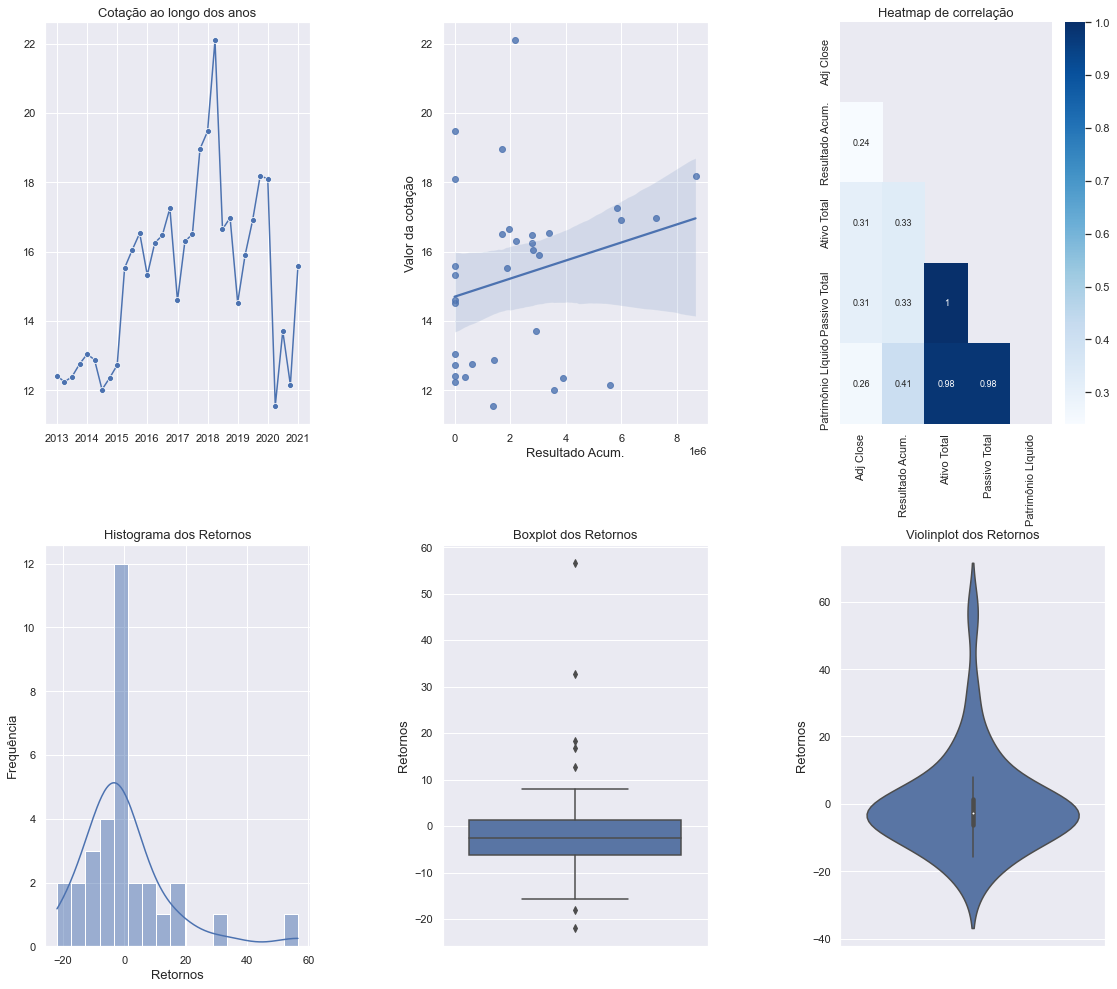

In [17]:
   def generate_graphs(Empresa):
    
    df = fundamentos[Empresa]
    df = df.rename(columns = {"Lucros/Prejuízos Acumulados" : "Resultado Acum."})
    plt.figure(figsize = (16, 14))
    fig, ax = plt.subplots(2, 3, figsize = (19, 17))
    plt.subplots_adjust(hspace = 0.3, wspace = 0.5)

    # Gráfico de Linha
    sns.lineplot(data = df, x = df.index, y = "Adj Close", marker = "o", ax = ax[0, 0])
    ax[0, 0].set_title("Cotação ao longo dos anos", fontsize = 13)
    ax[0, 0].set_ylabel(" ")

    # Scatterplot com linha de regressão 
    sns.regplot(data = df, y = "Adj Close", x = "Resultado Acum.", ax = ax[0, 1])
    ax[0, 1].set_ylabel("Valor da cotação", fontsize = 13)
    ax[0, 1].set_xlabel("Resultado Acum.", fontsize = 13)

    # Mapa de Calor
    attributes_list = ["Adj Close", "Resultado Acum.", "Ativo Total", "Passivo Total", "Patrimônio Líquido"]
    mask = np.triu(df[attributes_list].corr())
    df_corr = df[attributes_list].corr().round(decimals = 2)
    sns.heatmap(df_corr, annot = True, annot_kws = {"fontsize" : 9}, fmt = "g", cmap = "Blues", mask = mask, ax = ax[0, 2])
    ax[0, 2].set_title("Heatmap de correlação", fontsize = 13)

    # Analisando Retorno
    df["Retorno"] = df["Adj Close"].pct_change() * 100 # Multiplicar por 100 para deixar valores em %
    df["Retorno ibov"] = df["IBOV"].pct_change() * 100
    df = df.dropna()
    # Histograma
    sns.histplot(data = df, x = "Retorno", kde = True,  ax = ax[1, 0])
    ax[1, 0].set_title("Histograma dos Retornos", fontsize = 13)
    ax[1, 0].set_ylabel("Frequência", fontsize = 13)
    ax[1, 0].set_xlabel("Retornos", fontsize = 13)

    # Boxplot
    sns.boxplot(data = df, y = "Retorno", ax = ax[1, 1])
    ax[1, 1].set_title("Boxplot dos Retornos", fontsize = 13)
    ax[1, 1].set_ylabel("Retornos", fontsize = 13)

    # Violinplot
    sns.violinplot(data = df, y = "Retorno", ax = ax[1, 2])
    ax[1, 2].set_title("Violinplot dos Retornos", fontsize = 13)        
    ax[1, 2].set_ylabel("Retornos", fontsize = 13)
    
    plt.show()
    
generate_graphs("ABEV3")

In [18]:
attributes_list = ["Adj Close", "Ativo Total", "Ativo Circulante",
                   "Ativo Realizável a Longo Prazo", "Passivo Total", 
                   "Passivo Circulante", "Passivo Não Circulante",
                   "Patrimônio Líquido", "Lucros/Prejuízos Acumulados",
                   "Reservas de Lucros", "Receita Líquida de Vendas e/ou Serviços",
                   "Custo de Bens e/ou Serviços Vendidos", "Resultado Bruto",
                   "Lucro/Prejuízo do Período"
                    ]

def generate_metrics(empresa):

    df_emp = fundamentos[empresa][attributes_list]

    _min = pd.DataFrame( df_emp.apply( min ) ).T
    _max = pd.DataFrame( df_emp.apply( max ) ).T
    mean = pd.DataFrame( df_emp.apply( np.mean ) ).T
    median = pd.DataFrame( df_emp.apply( np.median ) ).T
    std =  pd.DataFrame( df_emp.apply( np.std ) ).T
    skew = pd.DataFrame( df_emp.apply( lambda x: x.skew() ) ).T
    kurtosis = pd.DataFrame( df_emp.apply( lambda x: x.kurtosis() ) ).T

    d = pd.concat([_min, _max, mean, median, std, skew, kurtosis]).T.reset_index()
    d.columns = ["Atributes", "Min", "Max", "Mean", "Median", "std", "Skew","Kurtosis"]
    return d

In [19]:
generate_metrics("ABEV3")

,Atributes,Min,Max,Mean,Median,std,Skew,Kurtosis
0,Adj Close,1.155786e+01,2.209273e+01,1.528588e+01,1.557577e+01,2.513041e+00,0.463559,-0.049791
1,Ativo Total,1.340374e+06,1.270568e+08,8.139187e+07,8.302042e+07,2.683918e+07,-1.243901,3.202195
2,Ativo Circulante,7.164100e+04,3.909879e+07,2.204483e+07,2.223060e+07,8.351022e+06,-0.645098,1.504406
3,Ativo Realizável a Longo Prazo,0.000000e+00,1.714417e+07,6.783730e+06,6.010440e+06,3.306575e+06,0.816098,1.786633
4,Passivo Total,1.340374e+06,1.270568e+08,8.139187e+07,8.302042e+07,2.683918e+07,-1.243901,3.202195
5,Passivo Circulante,3.025900e+04,3.347796e+07,2.162698e+07,2.285031e+07,7.675639e+06,-1.346634,1.973632
6,Passivo Não Circulante,3.348800e+05,1.720732e+07,9.778602e+06,9.388595e+06,3.870725e+06,-0.157499,0.871606
7,Patrimônio Líquido,9.586280e+05,7.800628e+07,4.821765e+07,4.716611e+07,1.651384e+07,-0.985560,2.555534
8,Lucros/Prejuízos Acumulados,0.000000e+00,8.665336e+06,2.239810e+06,1.867697e+06,2.275301e+06,1.112424,0.805567
9,Reservas de Lucros,0.000000e+00,2.592006e+07,9.035222e+06,8.660235e+06,7.003540e+06,0.740315,-0.349696


In [20]:
def generate_corr(empresa):
    df_corr = fundamentos[empresa][attributes_list].corr().style.background_gradient(cmap = "Blues")
    return df_corr

In [21]:
generate_corr("ABEV3")

,Adj Close,Ativo Total,Ativo Circulante,Ativo Realizável a Longo Prazo,Passivo Total,Passivo Circulante,Passivo Não Circulante,Patrimônio Líquido,Lucros/Prejuízos Acumulados,Reservas de Lucros,Receita Líquida de Vendas e/ou Serviços,Custo de Bens e/ou Serviços Vendidos,Resultado Bruto,Lucro/Prejuízo do Período
Adj Close,1.000000,0.311835,0.275662,0.268169,0.311835,0.451861,0.205656,0.264190,0.236131,0.197187,0.296244,-0.275329,0.288163,0.099240
Ativo Total,0.311835,1.000000,0.980013,0.892158,1.000000,0.905129,0.939630,0.984296,0.330171,0.822695,0.810916,-0.921849,0.676119,0.398788
Ativo Circulante,0.275662,0.980013,1.000000,0.884962,0.980013,0.912191,0.913979,0.963579,0.297939,0.846535,0.815083,-0.926157,0.679882,0.411033
Ativo Realizável a Longo Prazo,0.268169,0.892158,0.884962,1.000000,0.892158,0.757838,0.909376,0.891644,0.311685,0.873375,0.667760,-0.853104,0.493787,0.354450
Passivo Total,0.311835,1.000000,0.980013,0.892158,1.000000,0.905129,0.939630,0.984296,0.330171,0.822695,0.810916,-0.921849,0.676119,0.398788
Passivo Circulante,0.451861,0.905129,0.912191,0.757838,0.905129,1.000000,0.740462,0.843211,0.168082,0.675157,0.814205,-0.841545,0.735167,0.489168
Passivo Não Circulante,0.205656,0.939630,0.913979,0.909376,0.939630,0.740462,1.000000,0.939356,0.278334,0.883255,0.710882,-0.876413,0.546967,0.251005
Patrimônio Líquido,0.264190,0.984296,0.963579,0.891644,0.984296,0.843211,0.939356,1.000000,0.407708,0.833660,0.777260,-0.909170,0.630921,0.376242
Lucros/Prejuízos Acumulados,0.236131,0.330171,0.297939,0.311685,0.330171,0.168082,0.278334,0.407708,1.000000,0.140911,-0.018029,-0.134669,-0.118987,-0.164957
Reservas de Lucros,0.197187,0.822695,0.846535,0.873375,0.822695,0.675157,0.883255,0.833660,0.140911,1.000000,0.653564,-0.854468,0.470226,0.272511


In [22]:
def generate_histograms(empresa):
    fundamentos[empresa][attributes_list].hist(figsize = (16, 14))

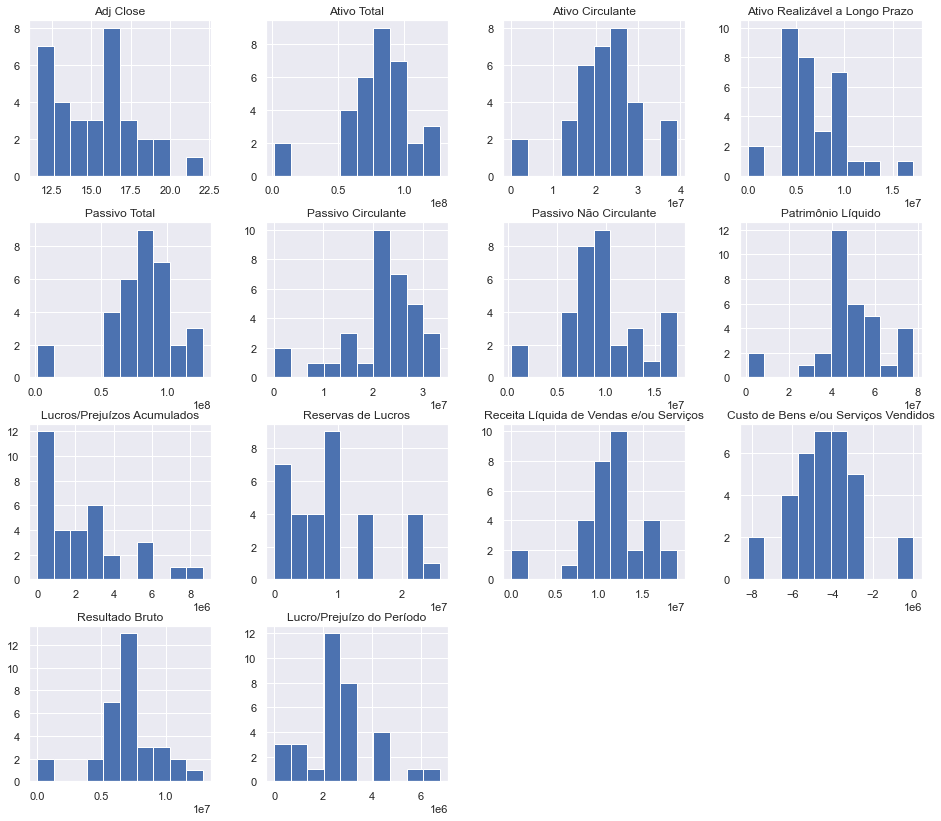

In [23]:
generate_histograms("ABEV3")

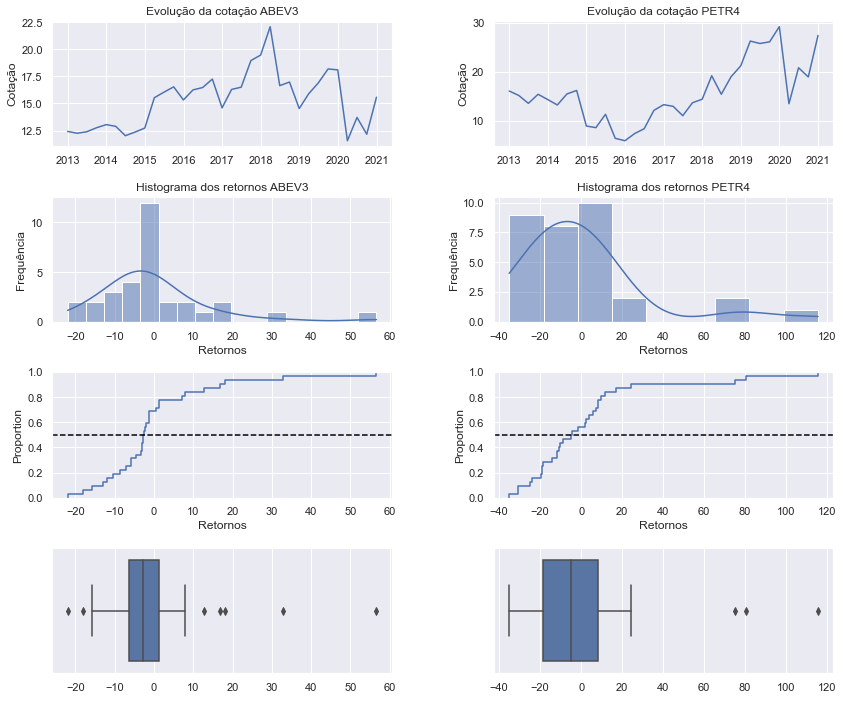

In [24]:
def generate_comparsion(A, B):
    a = pd.DataFrame( fundamentos[A]["Adj Close"] )
    if B == "IBOV":
        b = pd.DataFrame( fundamentos[A]["IBOV"] )
    else:
        b = pd.DataFrame( fundamentos[B]["Adj Close"] )
    
    fig, ax = plt.subplots( 4, 2, figsize = (14, 12) )
    plt.subplots_adjust(hspace = 0.4, wspace = 0.3)
    
    # Evolução Histórica das Cotações
    sns.lineplot(data = a, ax = ax[0, 0], legend = False)
    ax[0, 0].set_title(f'Evolução da cotação {A}', fontsize = 12)
    ax[0, 0].set_ylabel("Cotação", fontsize = 12)
    
    sns.lineplot(data = b, ax = ax[0, 1], legend = False)
    ax[0, 1].set_title(f'Evolução da cotação {B}', fontsize = 12)
    ax[0, 1].set_ylabel("Cotação", fontsize = 12)
    
    # RETORNOS
    a["Retornos"] = a.pct_change() * 100
    b["Retornos"] = b.pct_change() * 100
    
    # Histograma
    sns.histplot(data = a, x = "Retornos", kde = True, ax = ax[1, 0])
    ax[1, 0].set_title(f"Histograma dos retornos {A}", fontsize = 12)
    ax[1, 0].set_xlabel("Retornos", fontsize = 12)
    ax[1, 0].set_ylabel("Frequência", fontsize = 12)

    sns.histplot(data = b, x = "Retornos", kde = True, ax = ax[1, 1])
    ax[1, 1].set_title(f"Histograma dos retornos {B}", fontsize = 12)
    ax[1, 1].set_xlabel("Retornos", fontsize = 12)
    ax[1, 1].set_ylabel("Frequência", fontsize = 12)
    
    # Empirical Cumulative Distribution Function (ECDF)   
    sns.ecdfplot(data = a, x = "Retornos", ax = ax[2, 0])
    ax[2, 0].axhline(0.5, linestyle = "--", color = "black")
   
    sns.ecdfplot(data = b, x = "Retornos", ax = ax[2, 1])
    ax[2, 1].axhline(0.5, linestyle = "--", color = "black")
   
    # Boxplot
    sns.boxplot(data = a, x = "Retornos", ax = ax[3, 0])
    ax[3, 0].set_xlabel(" ")
    ax[3, 0].set_ylabel(" ")

    sns.boxplot(data = b, x = "Retornos", ax = ax[3, 1])
    ax[3, 1].set_xlabel(" ")
    ax[3, 1].set_ylabel(" ")

    plt.show()
    
generate_comparsion("ABEV3", "PETR4")

# <span style="color:lightblue"> 3.0. Data Preparation</span>

## 3.1. Transformar Indicadores em Percentual
Fundamentos tri = fundamentos tri / fundamentos tri anterior

Cotação tri = cotação tri seguinte / cotação tri

## 3.2. Criar os rótulos: Comprar, Não Comprar e Vender

Não queremos saber quando vender, mas inclui essa categoria para conseguir identificar quando que o nosso modelo vai sugerir uma compra quando na verdade o melhor momento era vender. Isso significa que o modelo errou "mais" do que quando sugeriu comprar e o correto era não comprar

Regra: 
1. Subiu mais do que o Ibovespa (ou caiu menos) -> Comprar (Valor = 2)
2. Subiu menos do que o Ibovespa até Ibovespa - 2% (ou caiu mais do que Ibovespa até Ibovespa -2%) -> Não Comprar (Valor = 1)
3. Subiu menos do que o Ibovespa - 2% (ou caiu mais do que Ibovespa -2%) -> Vender (Valor = 0)

In [15]:
fundamentos_copy = fundamentos.copy()

for empresa in fundamentos_copy:
    fundamento = fundamentos_copy[empresa]
    fundamento = fundamento.sort_index()
    for coluna in fundamento:
        if "Adj Close" in coluna or "IBOV" in coluna:
            pass
        else:
            # pegar fundamento anterior
            conditions_1 = [
                (fundamento[coluna].shift(1) > 0) & (fundamento[coluna] < 0),
                (fundamento[coluna].shift(1) < 0) & (fundamento[coluna] > 0),
                (fundamento[coluna].shift(1) < 0) & (fundamento[coluna] < 0),
                (fundamento[coluna].shift(1) == 0) & (fundamento[coluna] > 0),
                (fundamento[coluna].shift(1) == 0) & (fundamento[coluna] < 0),
                (fundamento[coluna].shift(1) < 0) & (fundamento[coluna] == 0)
            ] 
            values_1 = [
                -1,
                1,
                ( abs(fundamento[coluna].shift(1)) - abs(fundamento[coluna]) ) / abs(fundamento[coluna].shift(1)),
                1,
                -1,
                1
            ]
            fundamento[coluna] = np.select(conditions_1, values_1, default = fundamento[coluna] / fundamento[coluna].shift(1) - 1)
     # pegar cotação seguinte
    fundamento["Adj Close"] = fundamento["Adj Close"].shift(-1) / fundamento["Adj Close"] - 1
    fundamento["IBOV"] = fundamento["IBOV"].shift(-1) / fundamento["IBOV"] - 1
    fundamento["Resultado"] = fundamento["Adj Close"] - fundamento["IBOV"]
    conditions = [
        (fundamento["Resultado"] > 0),
        (fundamento["Resultado"] < 0) & (fundamento["Resultado"] >= -0.02),
        (fundamento["Resultado"] < -0.02)
    ]
    values = [2, 1, 0]
    fundamento["Decisão"] = np.select(conditions, values)
            
    fundamentos_copy[empresa] = fundamento
display(fundamentos_copy["ABEV3"])

,Ativo Total,Ativo Circulante,Caixa e Equivalentes de Caixa,Aplicações Financeiras,Contas a Receber_1,Estoques_1,Ativos Biológicos_1,Tributos a Recuperar,Despesas Antecipadas_1,Outros Ativos Circulantes,...,Receitas Financeiras,Despesas Financeiras,Resultado Antes Tributação/Participações,Provisão para IR e Contribuição Social,IR Diferido,Lucro/Prejuízo do Período,Adj Close,IBOV,Resultado,Decisão
2012-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.013860,-0.075469,0.061609,2
2013-03-31,-0.004402,0.082509,0.540941,NaN,-0.855514,NaN,NaN,-0.878257,NaN,NaN,...,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.011719,-0.157847,0.169566,2
2013-06-30,42.823044,154.470551,59.403415,1.000000,895.341086,1.000000,NaN,3040.654255,1.000000,1.000000,...,68.350400,-1.000000,240.798915,-3992.348051,1.000000,115.885753,0.029640,0.102851,-0.073211,0
2013-09-30,0.014976,0.034944,0.078755,0.259921,-0.012680,-0.051246,NaN,0.150925,-0.053987,0.184512,...,0.425526,-0.705429,0.312139,0.413319,-1.000000,1.005453,0.022673,-0.015878,0.038551,2
2013-12-31,0.151882,0.640439,1.334113,-0.528801,0.315030,0.080784,NaN,0.642232,0.326698,0.198435,...,2.318989,-1.081397,1.589715,-1.460893,0.573658,1.661370,-0.012411,-0.021201,0.008790,2
2014-03-31,-0.078297,-0.201158,-0.353510,0.421231,-0.139316,0.095442,NaN,0.016833,-0.133515,0.226973,...,-0.662614,0.593060,-0.616634,-0.048470,1.000000,-0.582090,-0.066860,0.054607,-0.121467,0
2014-06-30,-0.004866,-0.035410,-0.140116,-0.073713,0.137713,0.018993,NaN,0.063286,-0.189384,0.071060,...,0.329060,0.004367,-0.215038,0.699624,-0.923330,-0.149121,0.027849,0.017830,0.010019,2
2014-09-30,0.033925,-0.020712,-0.083799,0.386513,-0.074255,0.012343,NaN,0.129495,-0.024556,0.237706,...,0.250902,0.013409,0.323985,-1.989595,14.392936,0.298455,0.030113,-0.075929,0.106043,2
2014-12-31,0.107749,0.341943,0.691348,0.353403,-0.075340,0.079871,NaN,-0.072745,0.448937,2.030331,...,-0.001110,-0.646470,0.673428,1.000000,-1.000000,0.613021,0.219934,0.022857,0.197077,2
2015-03-31,0.041002,-0.071757,-0.282603,0.449956,-0.043301,0.283355,NaN,-0.118599,-0.102662,0.249493,...,-0.157968,0.171903,-0.285186,-1.000000,0.967386,-0.380692,0.033152,0.037752,-0.004600,1


In [16]:
# Remover valores vazios
cols = list(fundamentos_copy["ABEV3"].columns)
missing_values = dict.fromkeys(cols, 0)
total = 0

for empresa in fundamentos_copy:
    t = fundamentos_copy[empresa]
    total += t.shape[0]
    
    for col in cols:
        missings = pd.isnull(t[col]).sum()
        missing_values[col] += missings
        
print("Total de Linhas: ", total, "\n")
print(missing_values)

Total de Linhas:  2004 

{'Ativo Total': 61, 'Ativo Circulante': 61, 'Caixa e Equivalentes de Caixa': 61, 'Aplicações Financeiras': 623, 'Contas a Receber_1': 65, 'Estoques_1': 483, 'Ativos Biológicos_1': 1874, 'Tributos a Recuperar': 266, 'Despesas Antecipadas_1': 1059, 'Outros Ativos Circulantes': 281, 'Ativo Realizável a Longo Prazo': 61, 'Aplicações Financeiras Avaliadas a Valor Justo': 1581, 'Aplicações Financeiras Avaliadas ao Custo Amortizado': 1661, 'Contas a Receber': 937, 'Estoques': 1434, 'Ativos Biológicos': 1823, 'Tributos Diferidos_1': 822, 'Despesas Antecipadas': 1130, 'Créditos com Partes Relacionadas': 1271, 'Outros Ativos Não Circulantes': 426, 'Investimentos': 345, 'Imobilizado': 62, 'Intangível': 86, 'Diferido': 2004, 'Passivo Total': 61, 'Passivo Circulante': 61, 'Obrigações Sociais e Trabalhistas': 390, 'Fornecedores': 153, 'Obrigações Fiscais': 102, 'Empréstimos e Financiamentos_1': 85, 'Passivos com Partes Relacionadas_1': 1476, 'Dividendos e JCP a Pagar': 763, 

In [17]:
remove_cols = []
for col in missing_values:
    if missing_values[col] > (total / 3):
        remove_cols.append(col)
        
for empresa in fundamentos_copy:
    fundamentos_copy[empresa] = fundamentos_copy[empresa].drop(remove_cols, axis = 1)
    fundamentos_copy[empresa] = fundamentos_copy[empresa].fillna(0)
    fundamentos_copy[empresa] = fundamentos_copy[empresa].drop(["Adj Close", "IBOV", "Resultado"], axis = 1)
    
print(fundamentos_copy["ABEV3"].shape)

(33, 47)


In [18]:
fundamentos_copy2 = fundamentos_copy.copy()

# 3.3. Concatenando todos os Dataframes em um só

In [19]:
df = pd.DataFrame()
for empresa in fundamentos_copy2:
    fundamentos_copy2[empresa] = fundamentos_copy2[empresa][1:-1]
    fundamentos_copy2[empresa] = fundamentos_copy2[empresa].reset_index(drop = True)
    df = df.append(fundamentos_copy2[empresa])
    
display(df)

,Ativo Total,Ativo Circulante,Caixa e Equivalentes de Caixa,Aplicações Financeiras,Contas a Receber_1,Estoques_1,Tributos a Recuperar,Outros Ativos Circulantes,Ativo Realizável a Longo Prazo,Outros Ativos Não Circulantes,...,Outras Despesas Operacionais,Resultado da Equivalência Patrimonial,Financeiras,Receitas Financeiras,Despesas Financeiras,Resultado Antes Tributação/Participações,Provisão para IR e Contribuição Social,IR Diferido,Lucro/Prejuízo do Período,Decisão
0,-0.004402,0.082509,0.540941,0.000000,-0.855514,0.000000,-0.878257,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2
1,42.823044,154.470551,59.403415,1.000000,895.341086,1.000000,3040.654255,1.000000,2.274961,1.000000,...,-281.496855,1.000000,-1.000000,68.350400,-1.000000,240.798915,-3992.348051,1.000000,115.885753,0
2,0.014976,0.034944,0.078755,0.259921,-0.012680,-0.051246,0.150925,0.184512,-0.007786,0.079940,...,0.156800,39.123711,-0.840737,0.425526,-0.705429,0.312139,0.413319,-1.000000,1.005453,2
3,0.151882,0.640439,1.334113,-0.528801,0.315030,0.080784,0.642232,0.198435,-0.023974,0.080787,...,-3.692296,0.909044,-0.618082,2.318989,-1.081397,1.589715,-1.460893,0.573658,1.661370,2
4,-0.078297,-0.201158,-0.353510,0.421231,-0.139316,0.095442,0.016833,0.226973,-0.062046,-0.039055,...,0.658483,0.059219,0.539649,-0.662614,0.593060,-0.616634,-0.048470,1.000000,-0.582090,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26,0.031644,0.028168,-0.481838,0.224456,-0.121143,0.000000,0.000000,-0.015853,0.102209,0.000000,...,0.161994,0.000000,-0.091126,0.345073,-0.168994,-0.247649,-1.000000,1.000000,-0.216981,2
27,-0.039680,-0.113458,0.216463,-0.302487,0.063002,0.000000,0.000000,0.334544,-0.048733,0.000000,...,1.000000,0.000000,-0.813999,-0.298814,-0.421378,-0.597406,1.000000,-1.000000,-0.619312,0
28,0.385180,1.257939,-0.151743,3.247502,-0.155226,0.000000,0.000000,0.284199,0.322417,0.000000,...,-1.000000,0.000000,0.268306,7.889552,-1.151573,1.874517,-1.000000,1.000000,1.891677,2
29,0.217202,-0.085474,0.964492,-0.255688,0.489504,0.000000,0.000000,0.311093,0.011341,0.000000,...,-13.986971,0.000000,-0.245308,-0.645767,0.395478,-1.000000,0.079702,0.791087,-1.000000,0


# <span style="color:lightblue"> 4.0. Análise exploratória na base completa</span>

2    50.00%
0    43.73%
1     6.27%
Name: Decisão, dtype: object

<AxesSubplot:>

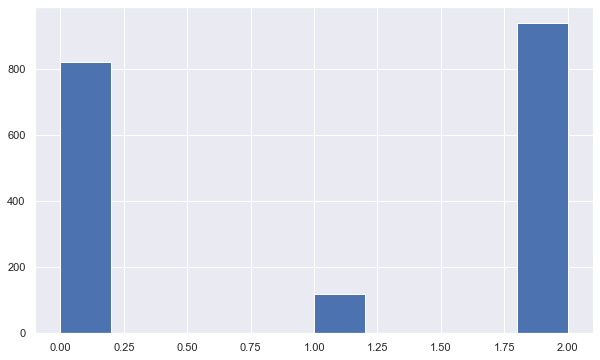

In [22]:
display(df["Decisão"].value_counts(normalize = True).map("{:.2%}".format))
df["Decisão"].hist()

1    50.00%
0    50.00%
Name: Decisão, dtype: object

<AxesSubplot:>

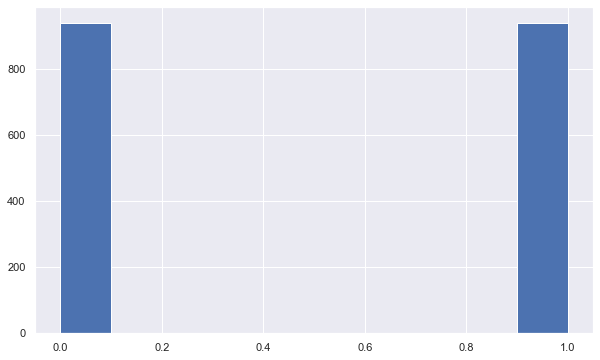

In [23]:
# Transformar categoria 1 em 0 e categoria 2 em 1
df.loc[df["Decisão"] == 1, "Decisão"] = 0
df.loc[df["Decisão"] == 2, "Decisão"] = 1
display(df["Decisão"].value_counts(normalize = True).map("{:.2%}".format))
df["Decisão"].hist()

<AxesSubplot:>

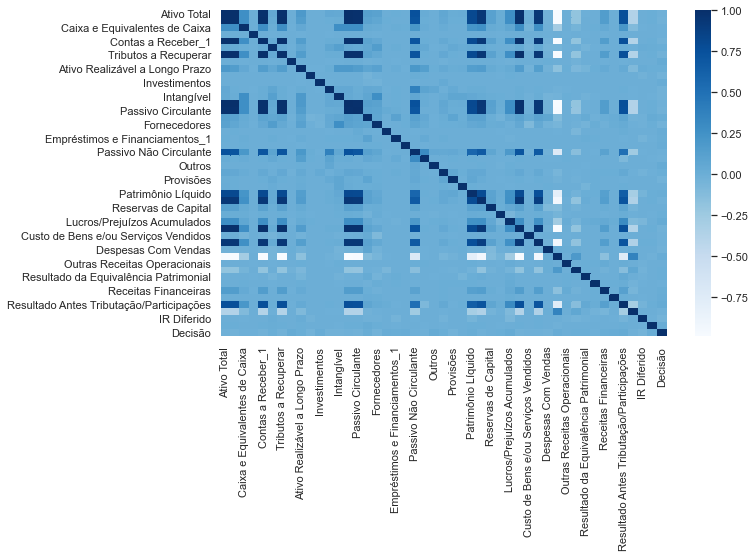

In [32]:
df_corr = df.corr()
sns.heatmap(df_corr, cmap = "Blues")

Por se tratar de dados de Demonstrações Contábeis, algumas variáveis acabam por ser redundantes. Por exemplo, o Ativo Total explica praticamentes todas as outras variáveis que também estão no ativo (AC e Realizável, realizável a longo prazo e seus componentes), assim como o Ativo Circulante explica todas as que se localizam dentro do próprio AC. Fora isso, ainda teremos o caso de correlação perfeita entre o Ativo Total e o Passivo Total já que, nesse caso, se considera o Passivo Total como sendo os Passivos Circ e não circ + o Patrimônio Líquido, valores que combinados devem ser exatamente iguais ao Ativo Total.

In [24]:
def get_correlations():
    corr = []
    df_corr = df.corr()
    for col in df_corr:
        for line in df_corr.index:
            if line != col:
                value = abs(df_corr.loc[line, col])
                if value > 0.8 and (col, line, value) not in corr:
                    corr.append( (line, col, value) )
                    print(f'Coeficiente de Correlação: {line} e {col}. Valor: {value}')
                    
get_correlations()

Coeficiente de Correlação: Ativo Circulante e Ativo Total. Valor: 0.9936191613034179
Coeficiente de Correlação: Contas a Receber_1 e Ativo Total. Valor: 0.9897313992744253
Coeficiente de Correlação: Tributos a Recuperar e Ativo Total. Valor: 0.9911861955025214
Coeficiente de Correlação: Passivo Total e Ativo Total. Valor: 1.0
Coeficiente de Correlação: Passivo Circulante e Ativo Total. Valor: 0.985689810713661
Coeficiente de Correlação: Patrimônio Líquido e Ativo Total. Valor: 0.8121568265673567
Coeficiente de Correlação: Capital Social Realizado e Ativo Total. Valor: 0.9407784719550618
Coeficiente de Correlação: Receita Líquida de Vendas e/ou Serviços e Ativo Total. Valor: 0.991369135249478
Coeficiente de Correlação: Resultado Bruto e Ativo Total. Valor: 0.9357493661129017
Coeficiente de Correlação: Despesas Gerais e Administrativas e Ativo Total. Valor: 0.9844249841100222
Coeficiente de Correlação: Contas a Receber_1 e Ativo Circulante. Valor: 0.9951703200197678
Coeficiente de Correl

In [25]:
remove = ["Ativo Circulante", "Contas a Receber_1", "Tributos a Recuperar", 
          "Passivo Total", "Passivo Circulante", "Patrimônio Líquido", 
          "Capital Social Realizado", "Receita Líquida de Vendas e/ou Serviços",
         "Resultado Bruto", "Despesas Gerais e Administrativas"
         ]
df = df.drop(remove, axis = 1)

get_correlations()

In [26]:
df.shape

(1882, 37)

In [27]:
df_describe = df.describe().T
df_describe["Skew"] = df.apply( lambda x: x.skew() )
df_describe["Kurtosis"] = df.apply( lambda x: x.kurtosis() )

df_describe

,count,mean,std,min,25%,50%,75%,max,Skew,Kurtosis
Ativo Total,1882.0,0.053090,0.994762,-1.000000,-0.008860,0.016753,0.046819,42.823044,42.315134,1819.558152
Caixa e Equivalentes de Caixa,1882.0,0.379162,5.007863,-1.000000,-0.178639,0.011099,0.254903,146.570612,26.000347,725.784952
Aplicações Financeiras,1882.0,1.771793,38.977293,-1.000000,-0.064727,0.000000,0.131742,1426.520135,31.249395,1055.360549
Estoques_1,1882.0,0.045616,0.624167,-1.000000,-0.027148,0.000000,0.072387,24.022412,31.603111,1176.037493
Outros Ativos Circulantes,1882.0,5.491565,161.011633,-1.000000,-0.102026,0.000000,0.172038,4940.469720,30.646891,938.317690
Ativo Realizável a Longo Prazo,1882.0,0.063211,0.331058,-1.000000,-0.020156,0.022638,0.081453,6.028832,8.046739,101.112326
Outros Ativos Não Circulantes,1882.0,0.795805,22.478578,-1.000000,-0.015068,0.002225,0.058934,946.583430,39.940929,1670.067023
Investimentos,1882.0,15.954057,630.495256,-1.000000,-0.006891,0.000000,0.043182,27314.600000,43.202220,1871.283337
Imobilizado,1882.0,0.079756,1.418217,-1.000000,-0.012732,0.007789,0.038594,56.006602,34.810995,1319.856793
Intangível,1882.0,0.100619,1.473478,-1.000000,-0.008638,0.001435,0.026466,53.334974,28.840783,962.724032


In [28]:
# display(df)
df = df.reset_index(drop = True)
display(df)

,Ativo Total,Caixa e Equivalentes de Caixa,Aplicações Financeiras,Estoques_1,Outros Ativos Circulantes,Ativo Realizável a Longo Prazo,Outros Ativos Não Circulantes,Investimentos,Imobilizado,Intangível,...,Outras Despesas Operacionais,Resultado da Equivalência Patrimonial,Financeiras,Receitas Financeiras,Despesas Financeiras,Resultado Antes Tributação/Participações,Provisão para IR e Contribuição Social,IR Diferido,Lucro/Prejuízo do Período,Decisão
0,-0.004402,0.540941,0.000000,0.000000,0.000000,1.000000,0.000000,-1.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
1,42.823044,59.403415,1.000000,1.000000,1.000000,2.274961,1.000000,1.000000,1.000000,1.000000e+00,...,-281.496855,1.000000,-1.000000,68.350400,-1.000000,240.798915,-3992.348051,1.000000,115.885753,0
2,0.014976,0.078755,0.259921,-0.051246,0.184512,-0.007786,0.079940,0.153778,0.038721,-9.579691e-07,...,0.156800,39.123711,-0.840737,0.425526,-0.705429,0.312139,0.413319,-1.000000,1.005453,1
3,0.151882,1.334113,-0.528801,0.080784,0.198435,-0.023974,0.080787,0.265464,0.065069,1.018131e-02,...,-3.692296,0.909044,-0.618082,2.318989,-1.081397,1.589715,-1.460893,0.573658,1.661370,1
4,-0.078297,-0.353510,0.421231,0.095442,0.226973,-0.062046,-0.039055,0.975805,-0.024782,-2.286042e-02,...,0.658483,0.059219,0.539649,-0.662614,0.593060,-0.616634,-0.048470,1.000000,-0.582090,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1877,0.031644,-0.481838,0.224456,0.000000,-0.015853,0.102209,0.000000,0.013158,0.018970,1.935803e-02,...,0.161994,0.000000,-0.091126,0.345073,-0.168994,-0.247649,-1.000000,1.000000,-0.216981,1
1878,-0.039680,0.216463,-0.302487,0.000000,0.334544,-0.048733,0.000000,0.463203,-0.087430,1.122126e-01,...,1.000000,0.000000,-0.813999,-0.298814,-0.421378,-0.597406,1.000000,-1.000000,-0.619312,0
1879,0.385180,-0.151743,3.247502,0.000000,0.284199,0.322417,0.000000,0.000000,0.018787,6.666600e-03,...,-1.000000,0.000000,0.268306,7.889552,-1.151573,1.874517,-1.000000,1.000000,1.891677,1
1880,0.217202,0.964492,-0.255688,0.000000,0.311093,0.011341,0.000000,0.000000,0.328128,8.351055e-01,...,-13.986971,0.000000,-0.245308,-0.645767,0.395478,-1.000000,0.079702,0.791087,-1.000000,0


# <span style="color:lightblue"> 5.0. Aplicando técnincas de Machine Learning</span>

In [29]:
# Separando os dados em variáveis explicativa (X) e Target (y)
X = df.drop("Decisão", axis = 1)
y = df["Decisão"]

X.shape, y.shape

((1882, 36), (1882,))

## 5.1. Criando função para automatizar a geração de métricas de desempenho com Validação Cruzada

In [30]:
kfold = KFold(n_splits = 5, shuffle = True, random_state = 0)

def cross_validation(model, X, y):
    scoring = {
               'Precision': 'precision',
               'Recall': 'recall',
               'Accuracy': 'accuracy', 
               'F1-Score': 'f1', 
              }

    scores = pd.DataFrame(cross_validate(model, X, y, scoring = scoring, cv = kfold))

    metrics = pd.DataFrame(
        {
        "Precision": scores["test_Precision"].mean(),
        "Recall": scores["test_Recall"].mean(),
        "Accuracy": scores["test_Accuracy"].mean(),
        "F1-Score": scores["test_F1-Score"].mean(),
        },
        index = ["metrics"]
    )
   # print(model, "\n")
    return metrics

## 5.2. Criação de um modelo "Dummy" para servir de baseline

In [40]:
dummy = DummyClassifier(strategy = "stratified", random_state = 0)

cross_validation(dummy, X, y)

,Precision,Recall,Accuracy,F1-Score
metrics,0.502128,0.501192,0.502111,0.501316


## 5.3. Crindo e comparando diversos modelos com Validação Cruzada e escolhendo o melhor

In [31]:
modelos = {
    "AdaBoost": AdaBoostClassifier(random_state = 1),
    "DecisionTree": DecisionTreeClassifier(random_state = 1),
    "RandomForest": RandomForestClassifier(random_state = 1),
    "ExtraTree": ExtraTreesClassifier(random_state = 1),
    "GradientBoost": GradientBoostingClassifier(random_state = 1),
    "KNN": KNeighborsClassifier(),
    "LogisticRegression": LogisticRegression(random_state = 1),
    "NaiveBayes": GaussianNB(),
    "SVM": SVC(random_state = 1),
    "RedeNeural": MLPClassifier(random_state = 1, max_iter = 400),
    'XGBoost': XGBClassifier(random_state = 1),
    "LGBM": LGBMClassifier(random_state = 1)
}

In [34]:
names = list(modelos.keys())
models = list(modelos.values())

df_models = pd.DataFrame()
for mdl in models:
    m = cross_validation(mdl, X, y)
    df_models = df_models.append(m)
    
df_models = df_models.T
df_models.columns = names
df_models.T.sort_values(by = "Precision", ascending = False)

,Precision,Recall,Accuracy,F1-Score
LGBM,0.590345,0.582335,0.587669,0.584969
XGBoost,0.582153,0.558230,0.578111,0.568509
RandomForest,0.577707,0.557414,0.573857,0.565834
GradientBoost,0.575874,0.578973,0.576513,0.576975
AdaBoost,0.559465,0.576613,0.560579,0.567021
DecisionTree,0.551595,0.547273,0.551535,0.549006
LogisticRegression,0.544474,0.490106,0.516997,0.488840
ExtraTree,0.544110,0.525764,0.541987,0.532849
RedeNeural,0.536374,0.491658,0.532960,0.511040
NaiveBayes,0.514916,0.074568,0.501075,0.129789


## Escolhido: LGBM

# 5.4. Hyperparameter Fine Tuning

In [43]:
def treinar_modelo(params):
    learning_rate = params[0]
    num_leaves = params[1]
    min_child_samples = params[2]
    subsample = params[3]
    colsample_bytree = params[4]
    max_depth = params[5]
    n_estimators = params[6]
    
    print(params, "\n")
    
    mdl = LGBMClassifier(
                        learning_rate = learning_rate,
                        num_leaves = num_leaves,
                        min_child_samples = min_child_samples,
                        subsample = subsample,
                        colsample_bytree = colsample_bytree,
                        max_depth = max_depth,
                        n_estimators = n_estimators,
                        random_state = 1
                       )
    
    score = np.mean(cross_val_score(estimator = mdl, X = X, y = y, cv = kfold, scoring = "precision"))
    return -score
    
# Espaço
space = [
    (1e-3, 1e-1, "log-uniform"), # learning_rate
    (20, 3000),   # num_leaves
    (1, 100),    # min_child_samples
    (0.05, 1.0), # subsample
    (0.1, 1.0),  # colsample_bytree
    (3, 12),     # max_depth
    (100, 1000)   # n_estimators
]

## 5.4.1. Random Search

In [44]:
result = dummy_minimize(treinar_modelo, space, random_state = 1, verbose = 1, n_calls = 30)

Iteration No: 1 started. Evaluating function at random point.
[0.09871192514273254, 1116, 10, 0.3372159440002478, 0.23208030173540176, 3, 229] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.5779
Function value obtained: -0.5816
Current minimum: -0.5816
Iteration No: 2 started. Evaluating function at random point.
[0.002357873072646739, 2817, 7, 0.9387621172657303, 0.8616798250174155, 8, 568] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 31.3666
Function value obtained: -0.5701
Current minimum: -0.5816
Iteration No: 3 started. Evaluating function at random point.
[0.0025639201733163104, 688, 30, 0.5576932134996663, 0.9225658221213098, 10, 853] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 26.3718
Function value obtained: -0.5863
Current minimum: -0.5863
Iteration No: 4 started. Evaluating function at random point.
[0.0019088591198098551, 1908, 87, 0.8107073402417599, 0.9714354181474579, 9, 413] 

Iteration No: 4 en

In [45]:
result.x

[0.09499968774647323,
 2264,
 26,
 0.3164217924611849,
 0.8103513956063397,
 12,
 716]

## 5.4.2. Bayesian Optimization

In [46]:
results_gp = gp_minimize(treinar_modelo, space, random_state = 1, verbose = 1, n_calls = 30, n_random_starts = 10)

Iteration No: 1 started. Evaluating function at random point.
[0.09871192514273254, 2799, 14, 0.9990884895579377, 0.3124800792567785, 7, 449] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 4.0058
Function value obtained: -0.5987
Current minimum: -0.5987
Iteration No: 2 started. Evaluating function at random point.
[0.02185204436698224, 2808, 85, 0.3476098410856614, 0.5720933436155844, 7, 307] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1.8432
Function value obtained: -0.5952
Current minimum: -0.5987
Iteration No: 3 started. Evaluating function at random point.
[0.011717307244555821, 2744, 46, 0.4591636388254731, 0.9452150104812633, 10, 744] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 11.5831
Function value obtained: -0.5984
Current minimum: -0.5987
Iteration No: 4 started. Evaluating function at random point.
[0.04031948793713315, 297, 52, 0.8717692393800344, 0.8462322166304276, 10, 346] 

Iteration No: 4 ended.

In [47]:
results_gp.x

[0.007803133051910397,
 682,
 8,
 0.49577660011623603,
 0.18655503440091553,
 11,
 208]

## 5.4.3. Forest Minimize

In [48]:
result_forest = forest_minimize(treinar_modelo, space, random_state = 1, verbose = 1, n_calls = 30)

Iteration No: 1 started. Evaluating function at random point.
[0.09871192514273254, 1116, 10, 0.3372159440002478, 0.23208030173540176, 3, 229] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.6070
Function value obtained: -0.5816
Current minimum: -0.5816
Iteration No: 2 started. Evaluating function at random point.
[0.002357873072646739, 2817, 7, 0.9387621172657303, 0.8616798250174155, 8, 568] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 23.0196
Function value obtained: -0.5701
Current minimum: -0.5816
Iteration No: 3 started. Evaluating function at random point.
[0.0025639201733163104, 688, 30, 0.5576932134996663, 0.9225658221213098, 10, 853] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 16.2760
Function value obtained: -0.5863
Current minimum: -0.5863
Iteration No: 4 started. Evaluating function at random point.
[0.0019088591198098551, 1908, 87, 0.8107073402417599, 0.9714354181474579, 9, 413] 

Iteration No: 4 en

In [49]:
result_forest.x

[0.005944092931756652,
 2945,
 25,
 0.8761653043719291,
 0.8937799268141381,
 12,
 940]

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

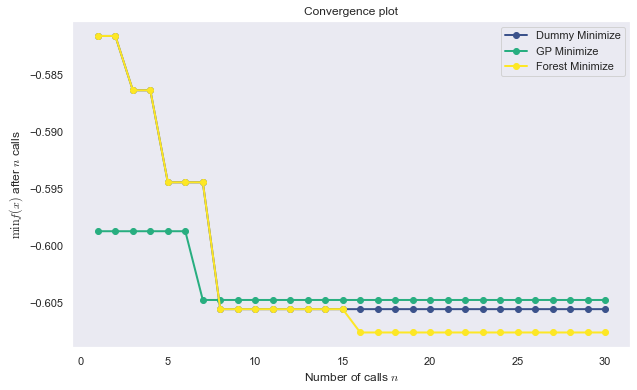

In [50]:
plot_convergence(
                 ("Dummy Minimize", result),
                 ("GP Minimize", results_gp),
                 ("Forest Minimize", result_forest),
                )

### Validação Cruzada no modelo "tunado"

In [35]:
mdl = LGBMClassifier(learning_rate = 0.005944092931756652,
                    num_leaves = 2945,
                    min_child_samples = 25,
                    subsample = 0.8761653043719291,
                    colsample_bytree = 0.8937799268141381,
                    max_depth = 12,
                    n_estimators = 940,
                    random_state = 1
                    )

cross_validation(mdl, X, y)

,Precision,Recall,Accuracy,F1-Score
metrics,0.607606,0.602334,0.606276,0.604215


### Validação Simples

In [36]:
Xtrain, Xval, ytrain, yval = train_test_split(X, y, train_size = 0.7, random_state = 72)

Xtrain.shape, Xval.shape, ytrain.shape, yval.shape

((1317, 36), (565, 36), (1317,), (565,))

In [37]:
mdl.fit(Xtrain, ytrain)
predict = mdl.predict(Xval)
precision_score(yval, predict)

0.6068702290076335

### Matriz de Confusão

LGBM
              precision    recall  f1-score   support

           0       0.56      0.62      0.59       272
           1       0.61      0.54      0.57       293

    accuracy                           0.58       565
   macro avg       0.58      0.58      0.58       565
weighted avg       0.58      0.58      0.58       565



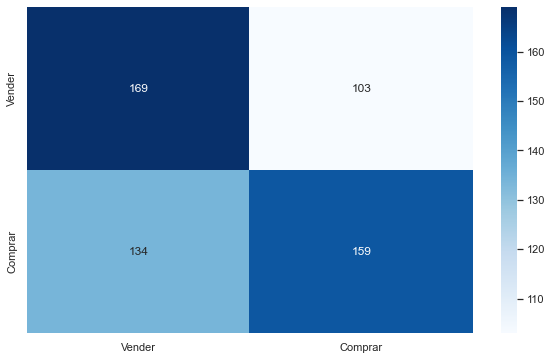

In [54]:
def avaliar(yval, predicts, nome_modelo):
    print(nome_modelo)
    report = classification_report(yval, predicts)
    print(report)
    cf_matrix = pd.DataFrame(confusion_matrix(yval, predicts), index=["Vender", "Comprar"], columns=["Vender", "Comprar"])
    sns.heatmap(cf_matrix, annot = True, cmap = "Blues", fmt = ',')
    plt.show()
      
avaliar(yval, predict, "LGBM")

# 5.5. Feature Selection
## 5.5.0. Descobrindo melhor número de features

In [38]:
k_vs_score = []
for k in range(2, 37): 
    selector = SelectKBest(score_func = f_classif, k = k)
    
    Xtrain2 = selector.fit_transform(Xtrain, ytrain)
    Xval2 = selector.transform(Xval)
    
    mdl.fit(Xtrain2, ytrain)
    
    p = mdl.predict(Xval2)
    
    score = precision_score(yval, p)
    print("k = {} - PRECISION = {}".format(k, score))
    
    k_vs_score.append(score)

k = 2 - PRECISION = 0.6108949416342413
k = 3 - PRECISION = 0.5526315789473685
k = 4 - PRECISION = 0.5511811023622047
k = 5 - PRECISION = 0.5454545454545454
k = 6 - PRECISION = 0.5622775800711743
k = 7 - PRECISION = 0.5555555555555556
k = 8 - PRECISION = 0.5655430711610487
k = 9 - PRECISION = 0.5902255639097744
k = 10 - PRECISION = 0.6254681647940075
k = 11 - PRECISION = 0.5909090909090909
k = 12 - PRECISION = 0.5765124555160143
k = 13 - PRECISION = 0.5924528301886792
k = 14 - PRECISION = 0.5795454545454546
k = 15 - PRECISION = 0.59375
k = 16 - PRECISION = 0.5985401459854015
k = 17 - PRECISION = 0.5947955390334573
k = 18 - PRECISION = 0.6037735849056604
k = 19 - PRECISION = 0.5931558935361216
k = 20 - PRECISION = 0.5912408759124088
k = 21 - PRECISION = 0.5897435897435898
k = 22 - PRECISION = 0.623574144486692
k = 23 - PRECISION = 0.594488188976378
k = 24 - PRECISION = 0.5931558935361216
k = 25 - PRECISION = 0.6086956521739131
k = 26 - PRECISION = 0.5886792452830188
k = 27 - PRECISION = 

<AxesSubplot:title={'center':'Gráfico de Quant de Variáveis x Precision'}, ylabel='0'>

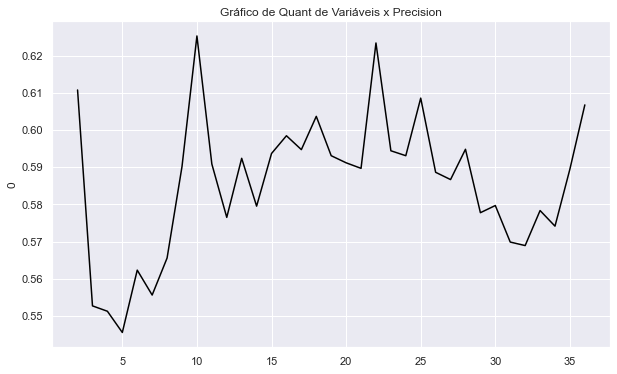

In [70]:
K = pd.DataFrame(k_vs_score, index = range(2, 37))

plt.title("Gráfico de Quant de Variáveis x Precision", fontsize = 12)
sns.lineplot(data = K, y = 0, x = K.index, color = "black")

Como podemos observar no gráfico K x Score, o valor de k ideal é bem instável e não se pode observar uma região que melhor o representa. Portanto, selecionaremos os valores de k onde o score foi mais alto e faremos o feature selection com cada um deles, exibindo seu score e, em seguida, efetuando uma Validação Cruzada utilizando apenas as features selecionadas e compararemos com o modelo utilizando todos os atributos a fim de chegar na conclusão mais robusta possível de quantas variáveis iremos utilizar.

## 5.5.1. Filter Method

In [67]:
# Valores de k a serem testados
k_list = [9, 10, 11, 13, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 28, 36]

In [68]:
for k in k_list:
    selector = SelectKBest(score_func = f_classif, k = k)
    selector.fit(Xtrain, ytrain)
    mask = selector.get_support()
    # Validação Simples
    Xtrain_selected = Xtrain.iloc[:, mask]
    Xval_selected = Xval.iloc[:, mask]
    mdl.fit(Xtrain_selected, ytrain)
    predict = mdl.predict(Xval_selected)
    p = precision_score(yval, predict)
    print("K = {} \n".format(k))
    print("Precision com Validação Simples = {} \n".format(p))
    # Validação Cruzada Apenas com as features selecionadas
    print("Validação Cruzada:\n")
    X_selected = X[Xtrain_selected.columns]
    display( cross_validation(mdl, X_selected, y) )
    print("-----------------------------------------------")

K = 9 

Precision com Validação Simples = 0.5902255639097744 

Validação Cruzada:



,Precision,Recall,Accuracy,F1-Score
metrics,0.55976,0.561963,0.559518,0.559966


-----------------------------------------------
K = 10 

Precision com Validação Simples = 0.6254681647940075 

Validação Cruzada:



,Precision,Recall,Accuracy,F1-Score
metrics,0.566741,0.569719,0.566416,0.567235


-----------------------------------------------
K = 11 

Precision com Validação Simples = 0.5909090909090909 

Validação Cruzada:



,Precision,Recall,Accuracy,F1-Score
metrics,0.575326,0.56565,0.573325,0.569494


-----------------------------------------------
K = 13 

Precision com Validação Simples = 0.5924528301886792 

Validação Cruzada:



,Precision,Recall,Accuracy,F1-Score
metrics,0.568846,0.570849,0.568568,0.56878


-----------------------------------------------
K = 15 

Precision com Validação Simples = 0.59375 

Validação Cruzada:



,Precision,Recall,Accuracy,F1-Score
metrics,0.574164,0.573374,0.573339,0.57262


-----------------------------------------------
K = 16 

Precision com Validação Simples = 0.5985401459854015 

Validação Cruzada:



,Precision,Recall,Accuracy,F1-Score
metrics,0.587183,0.583375,0.585558,0.583926


-----------------------------------------------
K = 17 

Precision com Validação Simples = 0.5947955390334573 

Validação Cruzada:



,Precision,Recall,Accuracy,F1-Score
metrics,0.576944,0.588244,0.578136,0.581293


-----------------------------------------------
K = 18 

Precision com Validação Simples = 0.6037735849056604 

Validação Cruzada:



,Precision,Recall,Accuracy,F1-Score
metrics,0.583063,0.587174,0.582894,0.584026


-----------------------------------------------
K = 19 

Precision com Validação Simples = 0.5931558935361216 

Validação Cruzada:



,Precision,Recall,Accuracy,F1-Score
metrics,0.582714,0.584249,0.583423,0.583169


-----------------------------------------------
K = 20 

Precision com Validação Simples = 0.5912408759124088 

Validação Cruzada:



,Precision,Recall,Accuracy,F1-Score
metrics,0.575892,0.579996,0.577047,0.57764


-----------------------------------------------
K = 22 

Precision com Validação Simples = 0.623574144486692 

Validação Cruzada:



,Precision,Recall,Accuracy,F1-Score
metrics,0.572878,0.569642,0.57228,0.570552


-----------------------------------------------
K = 23 

Precision com Validação Simples = 0.594488188976378 

Validação Cruzada:



,Precision,Recall,Accuracy,F1-Score
metrics,0.571242,0.567277,0.570688,0.568437


-----------------------------------------------
K = 24 

Precision com Validação Simples = 0.5931558935361216 

Validação Cruzada:



,Precision,Recall,Accuracy,F1-Score
metrics,0.574744,0.579651,0.575461,0.576238


-----------------------------------------------
K = 25 

Precision com Validação Simples = 0.6086956521739131 

Validação Cruzada:



,Precision,Recall,Accuracy,F1-Score
metrics,0.576483,0.57337,0.576528,0.573974


-----------------------------------------------
K = 28 

Precision com Validação Simples = 0.5948905109489051 

Validação Cruzada:



,Precision,Recall,Accuracy,F1-Score
metrics,0.571549,0.570274,0.570676,0.569563


-----------------------------------------------
K = 36 

Precision com Validação Simples = 0.6068702290076335 

Validação Cruzada:



,Precision,Recall,Accuracy,F1-Score
metrics,0.607606,0.602334,0.606276,0.604215


-----------------------------------------------


## 5.5.2. Wrapper Method - Recursive Feature Elimination (RFE)

In [69]:
for k in k_list:
    rfe = RFE(mdl, k)
    fit = rfe.fit(X, y)
    mask_rfe = fit.get_support()
    # Validação Simples
    Xtrain_selected_rfe = Xtrain.iloc[:, mask_rfe]
    Xval_selected_rfe = Xval.iloc[:, mask_rfe]
    mdl.fit(Xtrain_selected_rfe, ytrain)
    predict = mdl.predict(Xval_selected_rfe)
    p = precision_score(yval, predict)
    print("K = {} \n".format(k))
    print("Precision com Validação Simples = {} \n".format(p))
    # Validação Cruzada
    print("Validação Cruzada: \n")
    X_RFE = X[Xtrain_selected_rfe.columns]
    display( cross_validation(mdl, X_RFE, y) )
    print("-----------------------------------------------")

K = 9 

Precision com Validação Simples = 0.5740072202166066 

Validação Cruzada: 



,Precision,Recall,Accuracy,F1-Score
metrics,0.565051,0.568137,0.565383,0.565763


-----------------------------------------------
K = 10 

Precision com Validação Simples = 0.5897435897435898 

Validação Cruzada: 



,Precision,Recall,Accuracy,F1-Score
metrics,0.558269,0.573683,0.558995,0.564625


-----------------------------------------------
K = 11 

Precision com Validação Simples = 0.5957446808510638 

Validação Cruzada: 



,Precision,Recall,Accuracy,F1-Score
metrics,0.566319,0.5626,0.565372,0.563756


-----------------------------------------------
K = 13 

Precision com Validação Simples = 0.5910780669144982 

Validação Cruzada: 



,Precision,Recall,Accuracy,F1-Score
metrics,0.566922,0.563245,0.565361,0.56345


-----------------------------------------------
K = 15 

Precision com Validação Simples = 0.6273062730627307 

Validação Cruzada: 



,Precision,Recall,Accuracy,F1-Score
metrics,0.584679,0.585734,0.583973,0.584156


-----------------------------------------------
K = 16 

Precision com Validação Simples = 0.6273764258555133 

Validação Cruzada: 



,Precision,Recall,Accuracy,F1-Score
metrics,0.593545,0.604799,0.595117,0.597906


-----------------------------------------------
K = 17 

Precision com Validação Simples = 0.6373626373626373 

Validação Cruzada: 



,Precision,Recall,Accuracy,F1-Score
metrics,0.593381,0.599306,0.594063,0.595454


-----------------------------------------------
K = 18 

Precision com Validação Simples = 0.635036496350365 

Validação Cruzada: 



,Precision,Recall,Accuracy,F1-Score
metrics,0.583916,0.581761,0.582907,0.581684


-----------------------------------------------
K = 19 

Precision com Validação Simples = 0.6327272727272727 

Validação Cruzada: 



,Precision,Recall,Accuracy,F1-Score
metrics,0.595624,0.594214,0.594045,0.59375


-----------------------------------------------
K = 20 

Precision com Validação Simples = 0.6204379562043796 

Validação Cruzada: 



,Precision,Recall,Accuracy,F1-Score
metrics,0.583436,0.574748,0.581297,0.577901


-----------------------------------------------
K = 22 

Precision com Validação Simples = 0.6007604562737643 

Validação Cruzada: 



,Precision,Recall,Accuracy,F1-Score
metrics,0.593825,0.602238,0.594052,0.596761


-----------------------------------------------
K = 23 

Precision com Validação Simples = 0.5992366412213741 

Validação Cruzada: 



,Precision,Recall,Accuracy,F1-Score
metrics,0.598985,0.606225,0.598307,0.600951


-----------------------------------------------
K = 24 

Precision com Validação Simples = 0.6148148148148148 

Validação Cruzada: 



,Precision,Recall,Accuracy,F1-Score
metrics,0.595527,0.594409,0.594592,0.593622


-----------------------------------------------
K = 25 

Precision com Validação Simples = 0.5875486381322957 

Validação Cruzada: 



,Precision,Recall,Accuracy,F1-Score
metrics,0.606157,0.60155,0.604155,0.602595


-----------------------------------------------
K = 28 

Precision com Validação Simples = 0.5921985815602837 

Validação Cruzada: 



,Precision,Recall,Accuracy,F1-Score
metrics,0.601213,0.59378,0.598837,0.596247


-----------------------------------------------
K = 36 

Precision com Validação Simples = 0.6068702290076335 

Validação Cruzada: 



,Precision,Recall,Accuracy,F1-Score
metrics,0.607606,0.602334,0.606276,0.604215


-----------------------------------------------


Após analisar todos os resultados pelos dois métodos e fazer o tradeoff entre Precisão x Parcimônia, foi decidido que será utilizado o número de features K = 19 selecionadas pelo método do RFE. Embora algumas combinações com mais features apresentaram uma Precision maior, não houve um aumento gritante e, a medida que adcionamos mais varáveis, aumentamos o grau de complexidade do modelo. Respeitando o princípio da parcimônia, foi decidido optar por um modelo mais simples (parcimonioso)

In [71]:
rfe = RFE(mdl, 19)
fit = rfe.fit(X, y)
mask_rfe = fit.get_support()
X_rfe = X.iloc[:, mask_rfe]
Xtrain_selected_rfe = Xtrain.iloc[:, mask_rfe]
Xval_selected_rfe = Xval.iloc[:, mask_rfe]
mdl.fit(Xtrain_selected_rfe, ytrain)
predict = mdl.predict(Xval_selected_rfe)
precision_score(yval, predict)

0.6327272727272727

# <span style="color:lightblue"> 6.0. Traduzindo o resultado para métricas de negócio</span>
## Testando a solução no último trimestre que se tem registro nos dados que possuímos (que não foi utilizado para treinar nem validar o modelo)

In [72]:
ult_tri_X = fundamentos_copy.copy()
df_teste = pd.DataFrame()
lista_empresas = []
for emp in ult_tri_X:
    ult_tri_X[emp] = ult_tri_X[emp][-1:]
    ult_tri_X[emp] = ult_tri_X[emp].reset_index(drop = True)
    df_teste = df_teste.append(ult_tri_X[emp])
    lista_empresas.append(emp)
    
display(df_teste)
print(lista_empresas)

,Ativo Total,Ativo Circulante,Caixa e Equivalentes de Caixa,Aplicações Financeiras,Contas a Receber_1,Estoques_1,Tributos a Recuperar,Outros Ativos Circulantes,Ativo Realizável a Longo Prazo,Outros Ativos Não Circulantes,...,Outras Despesas Operacionais,Resultado da Equivalência Patrimonial,Financeiras,Receitas Financeiras,Despesas Financeiras,Resultado Antes Tributação/Participações,Provisão para IR e Contribuição Social,IR Diferido,Lucro/Prejuízo do Período,Decisão
0,-0.014641,-0.096069,-0.210989,0.178183,0.035174,0.035968,-0.053483,0.464569,0.338638,0.000000,...,-2.201752,0.143065,1.000000,4.803230,0.271435,2.481764,1.000000,-1.000000,1.983122,0
0,0.021032,0.060388,0.114767,0.054163,0.191414,0.000000,0.097072,-0.601857,0.047464,0.000000,...,0.813033,0.236324,1.000000,0.397435,0.653082,0.040481,-0.796482,0.024238,-0.034832,0
0,-0.065052,-0.090455,-0.049868,-0.303305,0.019817,-0.104190,0.039895,-0.198159,0.136495,0.000000,...,-0.628015,0.000000,-0.140260,-1.000000,1.000000,0.362254,-0.062285,10.778637,0.956088,0
0,0.077453,0.757451,3.909083,0.000000,-1.000000,0.000000,0.000000,0.000000,0.260903,0.000000,...,-213.763780,2.023065,-0.056459,-0.209859,0.299164,1.953086,0.000000,0.000000,1.739273,0
0,-0.029646,-0.042750,-0.335301,0.003408,0.428888,0.073564,1.335030,0.474968,-0.029399,0.000000,...,0.815659,0.000000,-0.067332,1.109213,-0.216112,0.609079,-2.668301,1.000000,3.192166,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.059826,0.281415,0.404819,0.000000,0.453531,-0.135756,-0.009355,0.769217,-0.117712,-0.465480,...,-9.237912,-6.941333,0.500872,-0.063966,0.480029,-0.724239,-1.607730,1.000000,-0.691015,0
0,-0.004568,-0.144531,-0.310447,0.000000,-0.022350,0.216183,-0.125387,-0.060282,-0.001100,-0.112840,...,0.265281,-0.151625,-16.417323,-0.548024,-0.069133,0.094810,1.000000,-0.284516,0.067110,0
0,0.099594,0.079650,0.406221,0.000000,0.003426,0.108797,-0.061279,0.032653,0.223863,0.054348,...,-0.558935,-0.250000,0.336449,0.000000,0.000000,-0.973077,0.000000,0.000000,-0.430508,0
0,0.046146,0.084131,0.487545,-0.395777,-0.041297,0.042082,-0.040685,0.203724,-0.188943,0.000000,...,-0.275642,-0.817027,1.000000,0.273026,-0.054605,0.107135,-0.119981,1.451443,0.152089,0


['ABEV3', 'B3SA3', 'BEEF3', 'BRAP4', 'BRFS3', 'BRKM5', 'BRML3', 'BTOW3', 'CCRO3', 'CIEL3', 'CMIG4', 'COGN3', 'CPFE3', 'CPLE6', 'CSAN3', 'CSNA3', 'CYRE3', 'ECOR3', 'EGIE3', 'ELET6', 'EMBR3', 'ENBR3', 'ENEV3', 'ENGI11', 'EQTL3', 'EZTC3', 'FLRY3', 'GGBR4', 'GOAU4', 'GOLL4', 'HGTX3', 'HYPE3', 'IGTA3', 'ITSA4', 'JBSS3', 'JHSF3', 'LAME4', 'LCAM3', 'LREN3', 'MGLU3', 'MRFG3', 'MRVE3', 'MULT3', 'PCAR3', 'PETR4', 'PRIO3', 'QUAL3', 'RADL3', 'RENT3', 'SBSP3', 'SULA11', 'SUZB3', 'TAEE11', 'TOTS3', 'UGPA3', 'USIM5', 'VALE3', 'VIVT3', 'VVAR3', 'WEGE3', 'YDUQ3']


In [73]:
df_teste = df_teste.reset_index(drop = True)
X_teste = df_teste[X_rfe.columns]
X_teste.head()

,Ativo Total,Outros Ativos Circulantes,Ativo Realizável a Longo Prazo,Investimentos,Imobilizado,Obrigações Sociais e Trabalhistas,Fornecedores,Obrigações Fiscais,Empréstimos e Financiamentos_1,Outros_1,Empréstimos e Financiamentos,Provisões,Lucros/Prejuízos Acumulados,Custo de Bens e/ou Serviços Vendidos,Outras Despesas Operacionais,Financeiras,Receitas Financeiras,Despesas Financeiras,Lucro/Prejuízo do Período
0,-0.014641,0.464569,0.338638,-0.008154,-0.026236,-0.247131,0.210281,0.247531,-0.365755,-0.150906,-0.190547,-0.046259,-1.000000,-0.104367,-2.201752,1.000000,4.803230,0.271435,1.983122
1,0.021032,-0.601857,0.047464,0.015850,0.087978,0.000000,0.585950,0.412882,0.952180,0.201262,0.020275,-0.136213,-1.000000,-1.830113,0.813033,1.000000,0.397435,0.653082,-0.034832
2,-0.065052,-0.198159,0.136495,1.000000,-0.030337,0.037647,0.073959,-0.065870,0.240625,-0.229577,-0.088840,-0.048121,-1.000000,-0.124991,-0.628015,-0.140260,-1.000000,1.000000,0.956088
3,0.077453,0.000000,0.260903,0.039711,-0.065217,0.000000,0.000000,756.474576,0.005437,0.022170,0.000000,0.003296,2.311917,0.000000,-213.763780,-0.056459,-0.209859,0.299164,1.739273
4,-0.029646,0.474968,-0.029399,-0.526215,-0.000952,-0.253162,0.134696,0.091583,-0.759008,-0.132282,-0.012563,0.049252,0.263530,-0.129168,0.815659,-0.067332,1.109213,-0.216112,3.192166


In [74]:
X_teste.shape

(61, 19)

### Realizando Predições

In [75]:
carteira_inicial = []
carteira_final = []

# Retreinando Modelo em todos os dados
mdl.fit(X_rfe, y)

# Efetuando predições
preds_teste = mdl.predict(X_teste)
print(preds_teste)
print("\n Empresas que Devem ser compradas: \n")

for i, empresa in enumerate(lista_empresas):
    if preds_teste[i] == 1:
        print(empresa)
        carteira_inicial.append(1000)
        cotacao = cotacoes[empresa]
        cotacao = cotacao.set_index("Date")
        cotacao_inicial = cotacao.loc["2020-12-31", "Adj Close"]
        cotacao_final = cotacao.loc["2021-03-31", "Adj Close"]
        percentual = cotacao_final / cotacao_inicial
        carteira_final.append(1000 * percentual)

[1 0 1 1 0 1 0 0 0 1 0 0 1 0 0 1 0 0 1 0 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 0
 0 0 1 1 0 1 0 0 1 1 1 1 0 0 1 0 1 1 0 0 0 0 1 0]

 Empresas que Devem ser compradas: 

ABEV3
BEEF3
BRAP4
BRKM5
CIEL3
CPFE3
CSNA3
EGIE3
EMBR3
ENBR3
EQTL3
EZTC3
FLRY3
GGBR4
GOAU4
GOLL4
HYPE3
IGTA3
ITSA4
JBSS3
JHSF3
MGLU3
MRFG3
MULT3
PRIO3
QUAL3
RADL3
RENT3
SUZB3
TOTS3
UGPA3
WEGE3


### Avaliando resultado e comparando com o índice Bovespa

In [76]:
# Retorno da carteira escolhida pelo modelo
saldo_inicial = sum(carteira_inicial)
saldo_final = sum(carteira_final)

print('Saldo Inicial: {} | Saldo Final: {}'.format(saldo_inicial, saldo_final))
print("Variação: ", saldo_final / saldo_inicial)

Saldo Inicial: 32000 | Saldo Final: 33662.14418695741
Variação:  1.0519420058424191


In [77]:
# Ibespa no mesmo período
variacao_ibov = df_ibov.loc["2021-03-31", "IBOV"] / df_ibov.loc["2020-12-31", "IBOV"]
print(variacao_ibov)

0.9776038086936114


A carteira de ações escolhida pelo modelo deu um retorno positivo de 5,19%, enquanto que o índice bovespa obteve -2,24%